In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

In [2]:
# Ensure the directory exists
plot_dir = 'results/plots'
os.makedirs(plot_dir, exist_ok=True)

# Ensure the directory exists  
model_dir = 'models/'
os.makedirs(model_dir, exist_ok=True)

# Ensure the directory exists  
data_dir = 'data/'
os.makedirs(data_dir, exist_ok=True)

# Ensure the directory exists
pred_dir = 'results/prediction/'
os.makedirs(pred_dir, exist_ok=True)

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


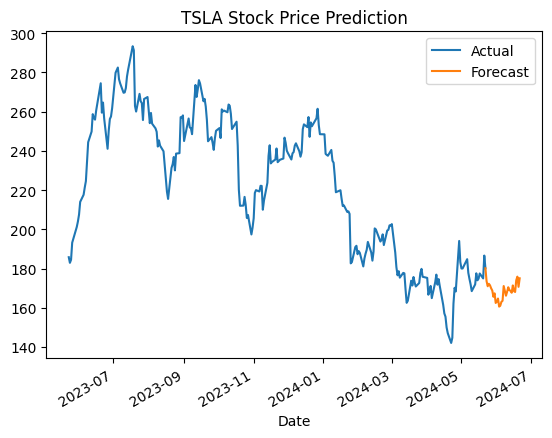

In [3]:
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

def stock_prediction(ticker, prediction_days):
    # download the data
    df = yf.download(tickers=[ticker], period='1y')
    if df.empty:
        raise ValueError(f"No data found for ticker {ticker}")
    
    y = df['Close'].ffill().values.reshape(-1, 1)
    
    # scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    y = scaler.fit_transform(y)
    
    # generate the input and output sequences
    n_lookback = 60  # length of input sequences (lookback period)
    n_forecast = prediction_days  # length of output sequences (forecast period)
    
    X = []
    Y = []
    
    for i in range(n_lookback, len(y) - n_forecast + 1):
        X.append(y[i - n_lookback: i])
        Y.append(y[i: i + n_forecast])
    
    X = np.array(X)
    Y = np.array(Y)
    
    # fit the model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(n_forecast))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, Y, epochs=100, batch_size=32, verbose=0)
    
    # generate the forecasts
    X_ = y[-n_lookback:]  # last available input sequence
    X_ = X_.reshape(1, n_lookback, 1)
    
    Y_ = model.predict(X_).reshape(-1, 1)
    Y_ = scaler.inverse_transform(Y_)
    
    # organize the results in a data frame
    df_past = df[['Close']].reset_index()
    df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
    df_past['Date'] = pd.to_datetime(df_past['Date'])
    df_past.loc[df_past.index[-1], 'Forecast'] = df_past.loc[df_past.index[-1], 'Actual']
    
    df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
    df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
    df_future['Forecast'] = Y_.flatten()
    df_future['Actual'] = np.nan
    
    results = pd.concat([df_past, df_future]).set_index('Date')
    
    # plot the results
    results.plot(title=f'{ticker} Stock Price Prediction')
    plt.savefig(os.path.join(plot_dir, f'{ticker}_predictions.png'))
    plt.show()
    return results

ticker='TSLA'
pred_days=30
results=stock_prediction(ticker, pred_days)


In [4]:
import holidays

# Remove holidays from the forecast
us_holidays = holidays.US()
resultspred = results[~results.index.isin(us_holidays.keys())]
resultspred = resultspred[~resultspred.index.weekday.isin([5, 6])]
resultspred = resultspred[~np.isnan(resultspred['Forecast'])]

In [5]:
# Create a DataFrame with dates and LSTM predictions

df_pred=resultspred.drop('Actual',axis=1)

# Save the DataFrame to a CSV file in the data folder
df_pred.to_csv(data_dir + f'{ticker}_predictions.csv', index=True)

# Save the DataFrame to a CSV file in the predictions folder
df_pred.to_csv(pred_dir+ f'{ticker}_predictions.csv', index=True)

In [6]:
df_pred

,Forecast
Date,
2024-05-22,180.110001
2024-05-23,173.558838
2024-05-24,170.966263
2024-05-27,169.906235
2024-05-28,168.782944
2024-05-29,165.572906
2024-05-30,167.353958
2024-05-31,162.438431
2024-06-03,160.584351
